## Current analysis with the Dolfyn python library

Available here:

https://dolfyn.readthedocs.io/en/latest/index.html

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt
import h5netcdf
import xarray as xr
import dolfyn as dlfn
from dolfyn.adv import api

Set up some functions for plotting later on:

In [2]:
def smooth_line(data, sigma = 2000):
    return gaussian_filter1d(data, sigma)


def quickplot(ncdata, var, direction = 1, smooth_tide=False):
    
    if direction == 0:
        cflow = 'red'
        direc = 'Cross-groove'
        print('Veloicty in cross-groove direction, NE is positive, SW is negative')
    if direction == 1:
        cflow = 'darkred'
        direc = 'Offshore'
        print('Veloicty in groove direction, + is offshore, - is onshore')
    if direction == 2:
        cflow = 'orange'
        direc = 'Vertical'
        print('Veloicty in vertical direction')
        
    fig, ax = plt.subplots(figsize=(10,5))

    ax2 = ax.twinx()
    ax2.plot(ncdata.variables['time'],ncdata.variables['vel'][direction], c= cflow, label = 'Current velocity (m/s)')
    
    if smooth_tide:
        ax.plot(ncdata.variables['time'],smooth_line(ncdata.variables[var][:]), label = 'Tide (dBar)')
    else:
        ax.plot(ncdata.variables['time'],ncdata.variables[var][:], label = 'Pressure (dBar)')
    pass
  
    plt.title('%s Flow velocity and tide at %s'%(direc, ncdata.deployment_name)) 
    
    ax.legend(loc = 2)
    ax2.legend(loc = 0)
    plt.grid()
    plt.show()

## Load the Data

In [3]:
files1 = ('data/AVC_2204.VEC')
ds = dlfn.read(files1)


## Trim the data set
#Remove data from before and after the deployment
#From the data we can see the start times for instrument 1 (AVC) is '2022-10-06 18:21:00' to '2022-10-08 08:47:00'
ds_start = '2022-10-06 18:21:00'
ds_end = '2022-10-08 08:47:00'

ds = ds.sel(time=slice(ds_start,ds_end))

print('AVC instrument trimmed to datetimes: %s and %s' %(ds_start, ds_end))


Reading file data/AVC_2204.VEC ...
AVC instrument trimmed to datetimes: 2022-10-06 18:21:00 and 2022-10-08 08:47:00


This runs the relevant functions of the dolfyn package. See text output. 

In [4]:
#Clean up the data by removing spikes:
#Dolfyn uses a method from Goring & Nikora et al.(2002)
mask = api.clean.GN2002(ds['vel'], npt=5000)
# Replace bad datapoints via cubic spline interpolation
ds['vel'] = api.clean.clean_fill(ds['vel'], mask, npt=12, method='cubic')

print('Percent of data (AVC) containing spikes: {0:.2f}%'.format(100*mask.mean()))


## Coordinate Rotations
#If the “earth” (ENU) coordinate system is specified, DOLfYN will automatically rotate the dataset 
#through the necessary coordinate systems to get there. 
#The inplace set as true will alter the input dataset “in place”, a.k.a. it not create a new dataset.

#We are using "earth" and we are rotating -16 deg to align with the groove.
##################################################################
### See map of True north (TN), Magnetic North (MN) and groove direction. 
##Big nortern groove is 16 deg beyond true north

declination =-9.7 # declination points 16 degrees west
##################################################################


print('Declination set to %s degrees' %(declination))
# First set the magnetic declination
dlfn.set_declination(ds, declin=declination, inplace=True) 


#Once in the true ENU frame of reference, we can calculate the principal flow direction for the velocity data and rotate it into the principal frame of reference (streamwise, cross-stream, vertical). 
#Principal flow directions are aligned with and orthogonal to the flow streamlines at the measurement location.
#First, the principal flow direction must be calculated through calc_principal_heading. As a standard for DOLfYN functions, those that begin with “calc_*” require the velocity data for input. This function is different from others in DOLfYN in that it requires place the output in an attribute called “principal_heading”, as shown below.
#Again we use rotate2 to change coordinate systems.
ds.attrs['principal_heading'] = dlfn.calc_principal_heading(ds['vel'])


dlfn.adp.clean.find_surface_from_P(ds, salinity=35)
print("Calculated depth. Instrument %s, Mean depth = %s" %(ds.deployment_name, ds.depth.mean().values))

Percent of data (AVC) containing spikes: 1.23%
Declination set to -9.7 degrees
Calculated depth. Instrument AVC_22, Mean depth = 3.5960345


## Lets take a look at the data:

Veloicty in cross-groove direction, NE is positive, SW is negative


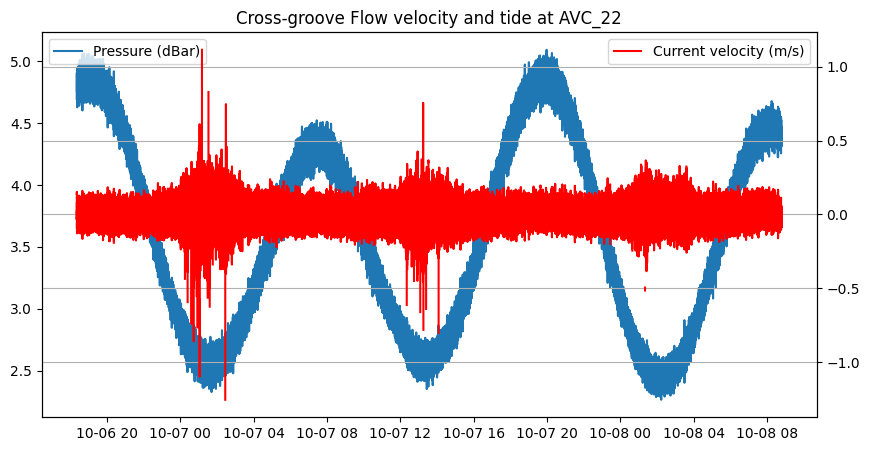

Veloicty in groove direction, + is offshore, - is onshore


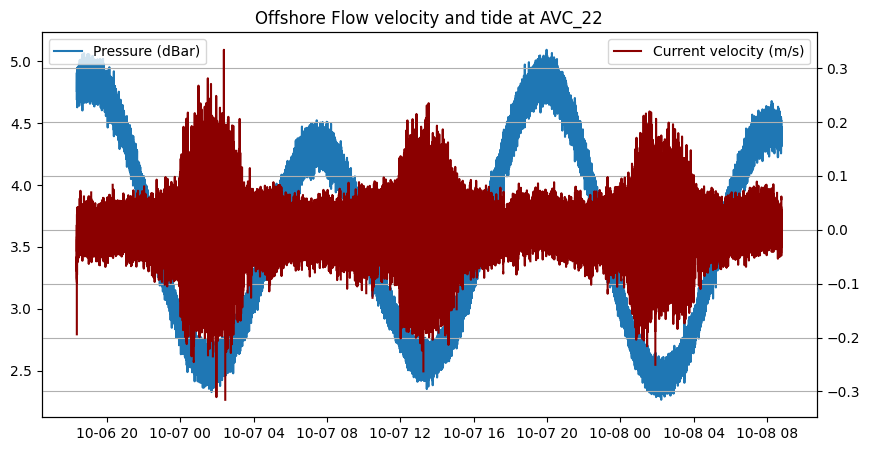

Veloicty in vertical direction


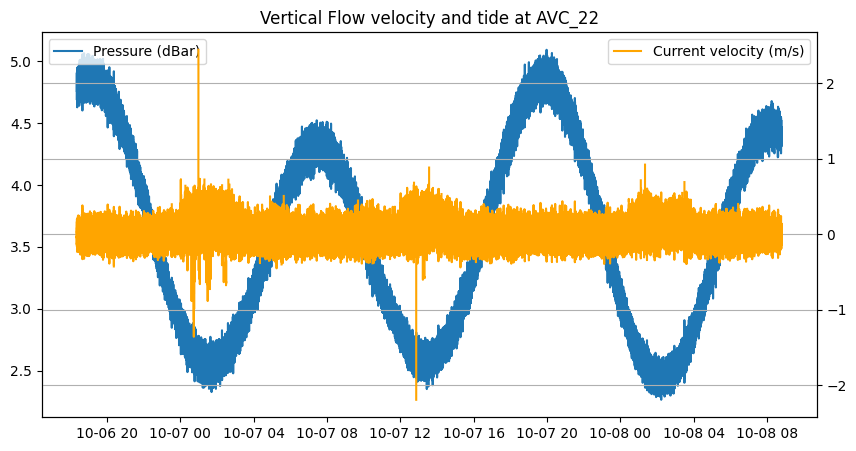

In [5]:
var = 'depth'
for direct in range (0,3):
    quickplot(ds, var, direction = direct, smooth_tide=False)
    #quickplot(ds2, var, direction = direct, smooth_tide=False)

### Calculate the absolute magnitude of the flow:

In [6]:
ds['vel_mag2D'] = np.sqrt((ds['vel'][0]*ds['vel'][0] +
                         ds['vel'][1]*ds['vel'][1]))

##Here consider flow in 3d - other direction analysis plots may condsider 2d 

ds['vel_mag3D'] = np.sqrt((ds['vel'][0]*ds['vel'][0] +
                         ds['vel'][1]*ds['vel'][1] +
                         ds['vel'][2]*ds['vel'][2]))


### Bin the data for flow analysis

In [7]:
## Bin for flow analysis #ds:
binner = api.ADVBinner(n_bin=ds.fs*600, fs=ds.fs, n_fft=ds.fs*150)
ds_binned = binner(ds, freq_units="Hz")
ds_binned = api.calc_turbulence(ds, n_bin=ds.fs*600, fs=ds.fs, n_fft=ds.fs*150, freq_units="Hz")
print('%s binned for spectral analysis'%(ds.deployment_name))

# Calculate the variance of each variable in the dataset and add to the averaged dataset
ds_binned = binner.do_var(ds, out_ds=ds_binned)

# Calculate the cross power spectral density
ds_binned['csd'] = binner.calc_csd(ds['vel'], freq_units='Hz', n_fft_coh=ds.fs*150)

# Calculated the turbulence intensity (requires a binned dataset)
ds_binned['TI'] = ds_binned.velds.I
print('%s: calculated turbulence statistics'%(ds.deployment_name))

ds_binned

AVC_22 binned for spectral analysis
AVC_22: calculated turbulence statistics


<xarray.Dataset>
Dimensions:               (time: 230, dir: 3, beam: 3, earth: 3, inst: 3,
                           tke: 3, tau: 3, S: 3, freq: 600, C: 3, coh_freq: 600)
Coordinates:
  * time                  (time) datetime64[ns] 2022-10-06T18:26:00.062028408...
  * dir                   (dir) <U1 'E' 'N' 'U'
  * beam                  (beam) int32 1 2 3
  * earth                 (earth) <U1 'E' 'N' 'U'
  * inst                  (inst) <U1 'X' 'Y' 'Z'
  * tke                   (tke) <U5 'upup_' 'vpvp_' 'wpwp_'
  * tau                   (tau) <U5 'upvp_' 'upwp_' 'vpwp_'
  * S                     (S) <U3 'Sxx' 'Syy' 'Szz'
  * freq                  (freq) float32 0.006667 0.01333 0.02 ... 3.993 4.0
  * C                     (C) <U3 'Cxy' 'Cxz' 'Cyz'
  * coh_freq              (coh_freq) float32 0.006667 0.01333 0.02 ... 3.993 4.0
Data variables: (12/42)
    U_std                 (time) float32 0.02666 0.02698 ... 0.02615 0.02606
    batt                  (time) float32 13.12 13.1 13.1 ... 11.6 11.6 11.6
    c_sound               (time) float32 1.53e+03 1.53e+03 ... 1.528e+03
    heading               (time) float32 207.8 208.6 208.8 ... 209.9 209.9 209.9
    pitch                 (time) float32 22.74 21.92 21.68 ... 21.14 21.15 21.13
    roll                  (time) float32 -20.47 -20.06 -19.98 ... -19.76 -19.76
    ...                    ...
    water_density_var     (time) float32 4.748e-06 1.598e-06 ... 7.335e-07
    depth_var             (time) float32 0.004006 0.004472 ... 0.003263 0.003504
    vel_mag2D_var         (time) float32 0.0007106 0.0007281 ... 0.000679
    vel_mag3D_var         (time) float32 0.003092 0.003739 ... 0.003022 0.003524
    csd                   (C, time, coh_freq) complex64 (nan+nanj) ... (nan+n...
    TI                    (time) float32 3.707 7.918 7.91 ... 1.164 1.55 3.538
Attributes: (12/46)
    inst_make:                   Nortek
    inst_model:                  Vector
    inst_type:                   ADV
    rotate_vars:                 ['vel']
    n_beams:                     3
    profile_mode:                continuous
    ...                          ...
    declination_in_orientmat:    1
    principal_heading:           74.0106
    n_bin:                       4800.0
    n_fft:                       1200.0
    n_fft_coh:                   1200
    description:                 Binned averages calculated from ensembles of...

### Plot Binned Energy Density Data

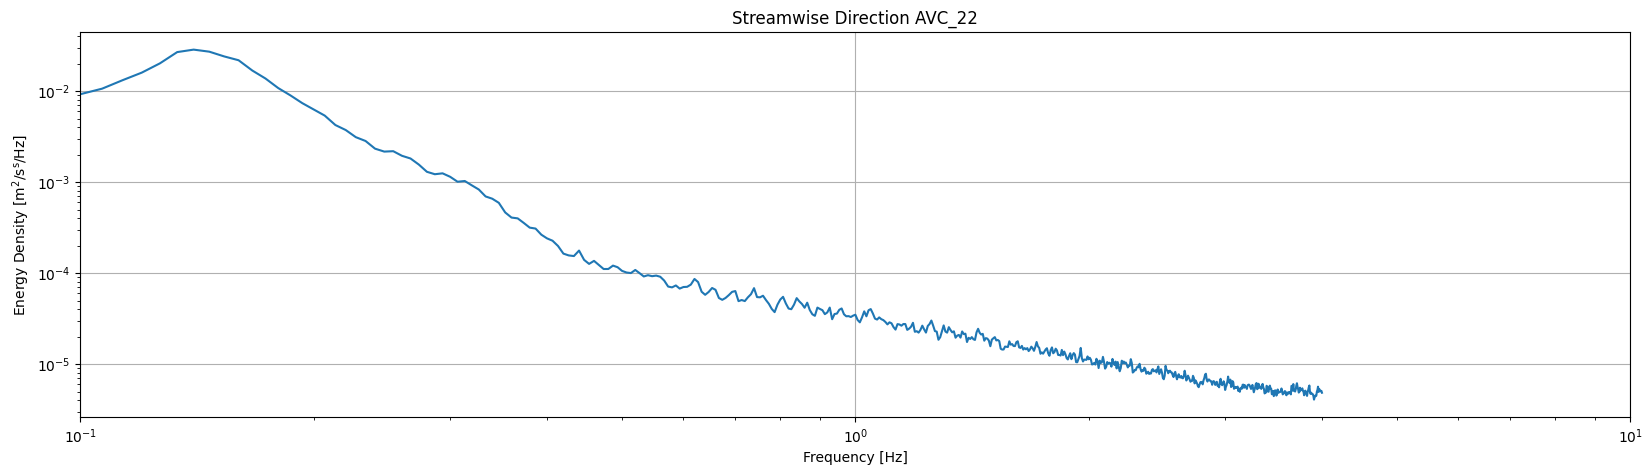

In [10]:
def plot_energy_density(data_binned):
    plt.figure(figsize=(20,5))
    plt.loglog(data_binned['freq'], data_binned['psd'].sel(S='Sxx').mean(dim='time'))
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy Density $\mathrm{[m^2/s^s/Hz]}$')
    plt.title('Streamwise Direction %s' %(data_binned.deployment_name))
    plt.xlim(0.1,10)
    plt.grid()

plot_energy_density(ds_binned)
#plot_energy_density(ds2_binned)

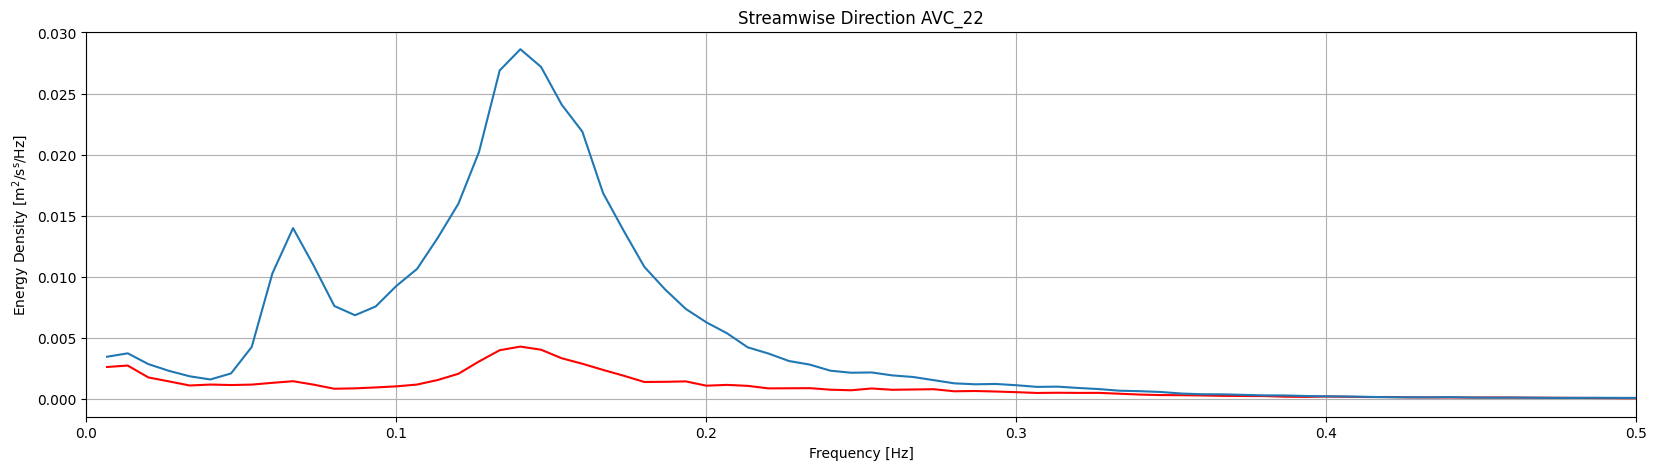

In [11]:
def plot_energy_density(data_binned):
    plt.figure(figsize=(20,5))
    plt.plot(data_binned['freq'], data_binned['psd'].sel(S='Syy').mean(dim='time'), c = 'r')
    plt.plot(data_binned['freq'], data_binned['psd'].sel(S='Sxx').mean(dim='time'))
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy Density $\mathrm{[m^2/s^s/Hz]}$')
    plt.title('Streamwise Direction %s' %(data_binned.deployment_name))
    plt.xlim(0,0.5)
    plt.grid()

plot_energy_density(ds_binned)

## Plot Streamwise Direction

C:\Users\deora\AppData\Local\Temp\ipykernel_28492\945069293.py:5: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 1)


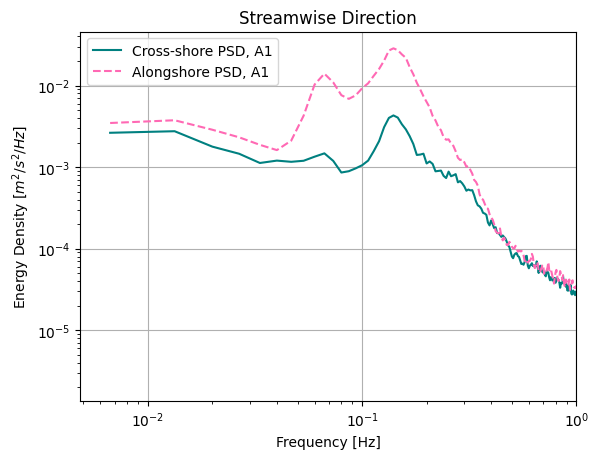

In [12]:
plt.figure()
plt.loglog(ds_binned['freq'], ds_binned['psd'].sel(S='Syy').mean(dim='time'), c='teal', label='Cross-shore PSD, A1')
plt.loglog(ds_binned['freq'], ds_binned['psd'].sel(S='Sxx').mean(dim='time'), c='#FF69B4', ls = '--', label='Alongshore PSD, A1')

plt.xlim(0, 1)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Energy Density [$m^2/s^2/Hz$]')
plt.title('Streamwise Direction')
plt.legend()
plt.grid(True)
plt.show()

## Tidal phase

In [14]:
### Find low tide times. This was done previously and put into a df called df_intervals.

df_tides = pd.read_csv('data/tidal_intervals.csv')
df_tides['cat1'] = ('high falling','low falling', 'low rising', 'high rising', 'high falling','low falling', 'low rising', 'high rising', 'high falling','low falling', 'low rising', 'high rising',)
df_tides['cat2'] = ('high', 'low', 'low', 'high','high', 'low', 'low', 'high','high', 'low', 'low', 'high')
df_tides

,time,depth,start,end,duration,interval,cat1,cat2
0,2022-10-06 19:02:06.999541,4.864288,2022-10-06 19:02:06.999541,2022-10-06 22:31:38.874652,0 days 03:29:31.875111,1,high falling,high
1,2022-10-06 22:31:38.874652,3.603790,2022-10-06 22:31:38.874652,2022-10-07 01:39:45.749752,0 days 03:08:06.875100,2,low falling,low
2,2022-10-07 01:39:45.749752,2.557291,2022-10-07 01:39:45.749752,2022-10-07 04:58:32.124857,0 days 03:18:46.375105,3,low rising,low
3,2022-10-07 04:58:32.124857,3.603800,2022-10-07 04:58:32.124857,2022-10-07 07:31:12.874938,0 days 02:32:40.750081,4,high rising,high
4,2022-10-07 07:31:17.249938,4.314948,2022-10-07 07:31:17.249938,2022-10-07 10:01:47.875018,0 days 02:30:30.625080,5,high falling,high
5,2022-10-07 10:01:47.875018,3.603799,2022-10-07 10:01:47.875018,2022-10-07 13:21:21.750124,0 days 03:19:33.875106,6,low falling,low
6,2022-10-07 13:21:21.750124,2.586361,2022-10-07 13:21:21.750124,2022-10-07 16:28:52.750223,0 days 03:07:31.000099,7,low rising,low
7,2022-10-07 16:28:52.750223,3.603789,2022-10-07 16:28:52.750223,2022-10-07 19:51:41.500331,0 days 03:22:48.750108,8,high rising,high
8,2022-10-07 19:51:41.500331,4.858463,2022-10-07 19:51:41.500331,2022-10-07 23:05:38.375434,0 days 03:13:56.875103,9,high falling,high
9,2022-10-07 23:05:38.375434,3.603796,2022-10-07 23:05:38.375434,2022-10-08 02:14:24.750534,0 days 03:08:46.375100,10,low falling,low


In [15]:
def split_tides(ds, df_tides):
    # Filter the DataFrame to get time intervals for low tide
    low_tide_intervals = df_tides[df_tides['cat2'] == 'low']

    # Initialize an empty list to store flow rates
    low_tide_flow_rates = []

    # Iterate through the low tide intervals and select the corresponding flow rates
    for index, row in low_tide_intervals.iterrows():
        start_time = row['start']
        end_time = row['end']

        # Use xarray's sel method to select flow rates within the low tide interval
        low_tide_data = ds.sel(time=slice(start_time, end_time))

        # Append the selected flow rates to the list
        low_tide_flow_rates.append(low_tide_data)

    # Merge the selected low tide flow rates into a single xarray dataset
    low_tide_flow_data = xr.concat(low_tide_flow_rates, dim='time')
    
    
        # Filter the DataFrame to get time intervals for high tide
    high_tide_intervals = df_tides[df_tides['cat2'] == 'high']

    # Initialize an empty list to store flow rates
    high_tide_flow_rates = []

    # Iterate through the high tide intervals and select the corresponding flow rates
    for index, row in high_tide_intervals.iterrows():
        start_time = row['start']
        end_time = row['end']

        # Use xarray's sel method to select flow rates within the high tide interval
        high_tide_data = ds.sel(time=slice(start_time, end_time))

        # Append the selected flow rates to the list
        high_tide_flow_rates.append(high_tide_data)

    # Merge the selected high tide flow rates into a single xarray dataset
    high_tide_flow_data = xr.concat(high_tide_flow_rates, dim='time')
    # Now, 'high_tide_flow_data' contains the flow rates at high tide intervals.
    return low_tide_flow_data, high_tide_flow_data

ds_low_tide, ds_high_tide = split_tides(ds, df_tides)

In [16]:
mean_flow_rate_high = ds_high_tide['vel_mag2D'].mean()
mean_flow_rate_low = ds_low_tide['vel_mag2D'].mean()


print('Inst A1')


# Calculate the percentage increase
percentage_increase = ((mean_flow_rate_low - mean_flow_rate_high) / mean_flow_rate_high) * 100

# Print the results
print("Mean Flow Rates:")
print(f"High Tide: {mean_flow_rate_high:.2f}")
print(f"Low Tide: {mean_flow_rate_low:.2f}")
print(f"Percentage Increase from High Tide to Low Tide: {percentage_increase:.2f}%")

Inst A1
Mean Flow Rates:
High Tide: 0.05
Low Tide: 0.07
Percentage Increase from High Tide to Low Tide: 57.23%


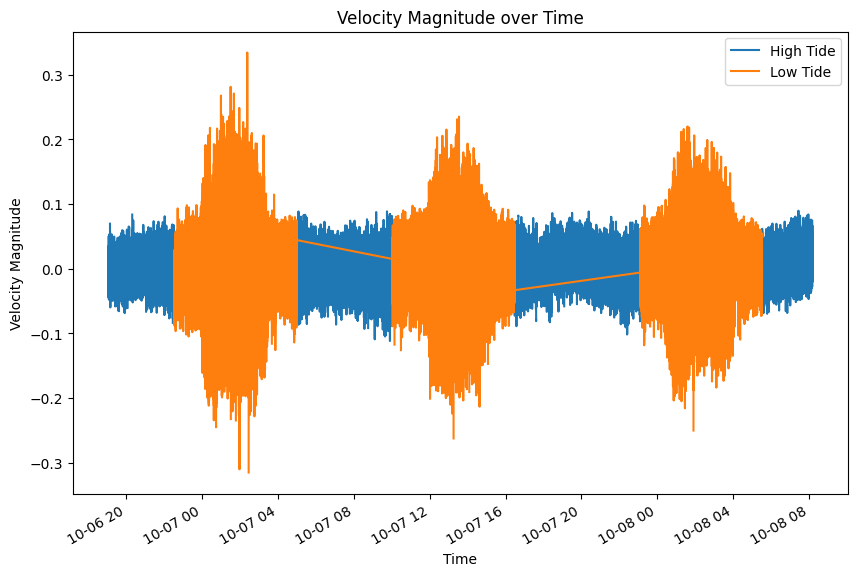

In [17]:
# Create a figure with a specific size
plt.figure(figsize=(10, 6))  # You can adjust the width (10) and height (6) as needed

# Assuming ds_high_tide and ds_low_tide are pandas Series or DataFrames
ds_high_tide['vel'][1].plot(label='High Tide')
ds_low_tide['vel'][1].plot(label='Low Tide')

# Customize the plot
plt.title('Velocity Magnitude over Time')
plt.xlabel('Time')
plt.ylabel('Velocity Magnitude')
plt.legend()

# Display the plot
plt.show()

## The max, min and mean current flows are resampled 

In [24]:
def add_hours(ds):
    time_data = ds['time'].values
    time_difference = ((time_data - time_data[0]) / np.timedelta64(1, 'h'))
    ds.coords['hours'] = xr.DataArray(time_difference, dims=['time'])
    return ds

In [25]:
ds_rsp_max = ds.resample(time="0.25H").max()
ds_rsp_mean = ds.resample(time="0.25H").mean()
ds_rsp_min = ds.resample(time="0.25H").min()
ds_rsp_max = add_hours(ds_rsp_max)
ds_rsp_mean = add_hours(ds_rsp_mean)
ds_rsp_min = add_hours(ds_rsp_min)

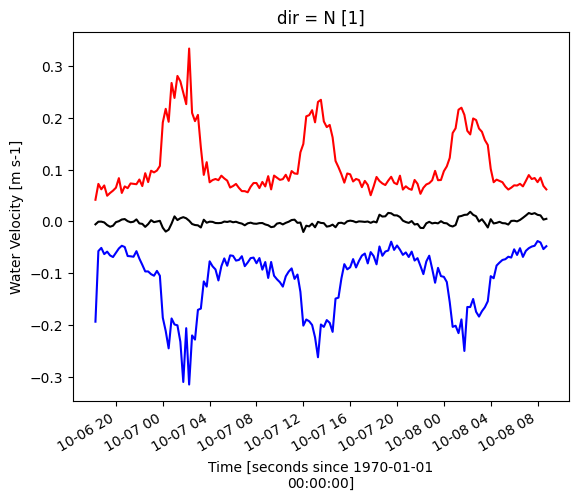

In [26]:

ds_rsp_max.vel[:,1].plot(color='r')
ds_rsp_mean.vel[:,1].plot(color='k')
ds_rsp_min.vel[:,1].plot(color='b')

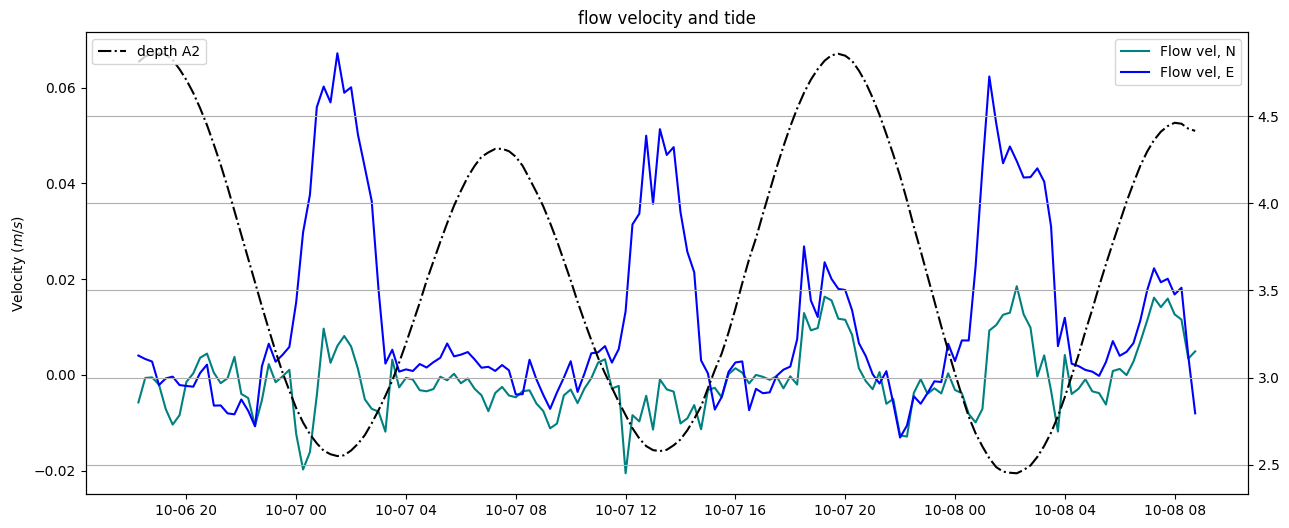

In [27]:
direction = 1
fig, ax = plt.subplots(figsize = (15,6))
ax2 = ax.twinx()
#ax.plot(ds.variables['time'],ds.variables['vel'][direction], label = 'All data', color = 'lightgrey')
#ax.plot(ds_rsp_max.time, ds_rsp_max.vel[:,direction], c ='r', label = 'max offshore')
#ax.plot(ds_rsp_mean.time, ds_rsp_mean.vel[:,direction], color='coral', label = 'mean flow, A1')

ax2.plot(ds_rsp_mean.time, ds_rsp_mean.depth, color='k',ls='-.', label = 'depth A2')
ax.plot(ds_rsp_mean.time, ds_rsp_mean.vel[:,direction], color='teal', label = 'Flow vel, N')
ax.plot(ds_rsp_mean.time, ds_rsp_mean.vel[:,0], color='b', label = 'Flow vel, E')
#ax.plot(ds_rsp_min.time, ds_rsp_min.vel[:,direction], color='b', label = 'max onshore')
ax.legend(loc = 1)
ax2.legend(loc = 2)
ax.set_title('flow velocity and tide')
ax.set_ylabel('Velocity $(m/s)$')
plt.grid()
#plt.savefig('max_min_%s_%s.png'%(direc, ds.deployment_name))

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


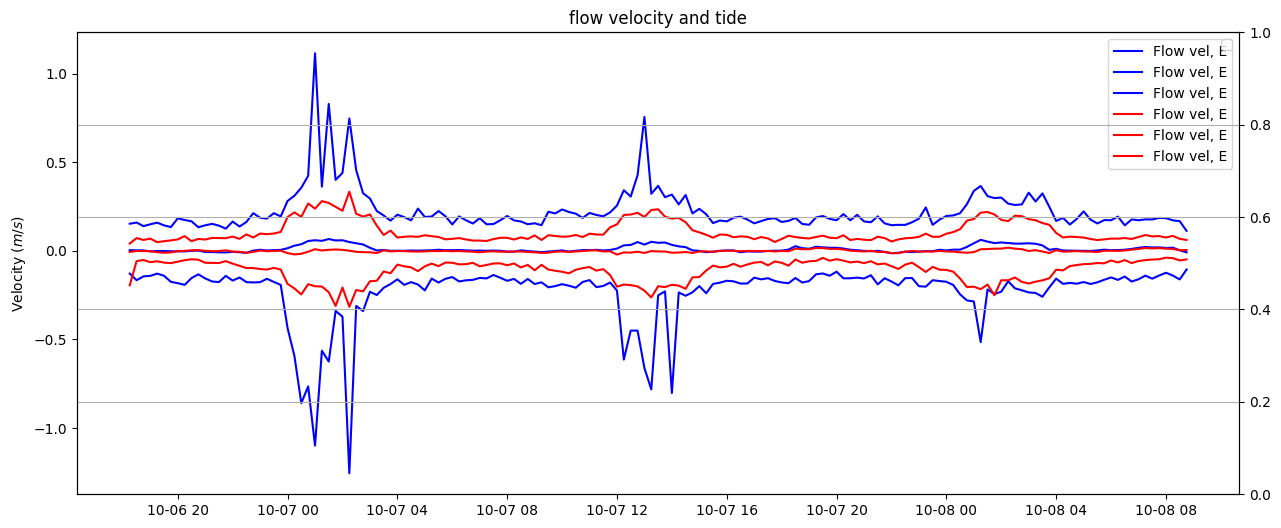

In [28]:
direction = 1
fig, ax = plt.subplots(figsize = (15,6))
ax2 = ax.twinx()
#ax.plot(ds.variables['time'],ds.variables['vel'][direction], label = 'All data', color = 'lightgrey')
#ax.plot(ds_rsp_max.time, ds_rsp_max.vel[:,direction], c ='r', label = 'max offshore')
ax.plot(ds_rsp_mean.time, ds_rsp_mean.vel[:,0], color='b', label = 'Flow vel, E')
ax.plot(ds_rsp_max.time, ds_rsp_max.vel[:,0], color='b', label = 'Flow vel, E')
ax.plot(ds_rsp_min.time, ds_rsp_min.vel[:,0], color='b', label = 'Flow vel, E')

ax.plot(ds_rsp_mean.time, ds_rsp_mean.vel[:,1], color='r', label = 'Flow vel, E')
ax.plot(ds_rsp_max.time, ds_rsp_max.vel[:,1], color='r', label = 'Flow vel, E')
ax.plot(ds_rsp_min.time, ds_rsp_min.vel[:,1], color='r', label = 'Flow vel, E')
#ax.plot(ds_rsp_min.time, ds_rsp_min.vel[:,direction], color='b', label = 'max onshore')
ax.legend()
ax2.legend()
ax.set_title('flow velocity and tide')
ax.set_ylabel('Velocity $(m/s)$')
plt.grid()
#plt.savefig('max_min_%s_%s.png'%(direc, ds.deployment_name))

plt.show()

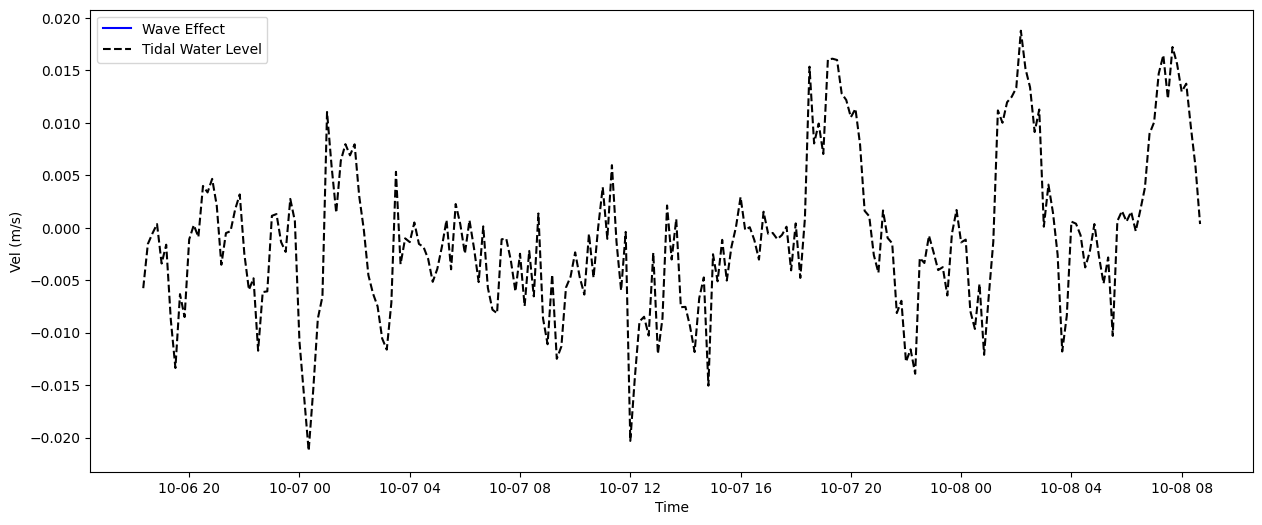

In [29]:



# Resample the DataFrame to a 10-minute interval and take the mean of each interval for tidal water level
ds_tidal = ds.resample(time = '10T').mean()

# Define the bandpass filter parameters for wave frequencies (5-12 seconds)
lowcut = 0.2  # 1/5 seconds (lower bound for wave frequencies)
highcut = 1.2  # 1/12 seconds (upper bound for wave frequencies)
fs = 8.0  # Sampling frequency (8Hz)

# Create the bandpass filter
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='band')

# Apply the bandpass filter to the depth data to isolate wave effects
wave_effect = filtfilt(b, a, ds['vel'])


# Create the plot for tidal water level
fig, ax = plt.subplots(figsize=(15, 6))

# Create the plot for the wave effect
ax.plot(ds.time, wave_effect[1,:], color='b', label='Wave Effect')


ax.plot(ds_tidal.time, ds_tidal['vel'][:,1], color='k', ls='--', label='Tidal Water Level')



# Customize the plot as needed
ax.set_xlabel('Time')
ax.set_ylabel('Vel (m/s)')
ax.legend()

# Show the plot
plt.show()

In [31]:
def get_direction(direction):
    if direction == 0:
        cflow = 'red'
        direc = 'Cross-shore'
        print('Veloicty in east-west direction, X-groove')
    if direction == 1:
        cflow = 'darkred'
        direc = 'Offshore'
        print('Veloicty in North South direction, + is offshore, - is onshore')
    if direction == 2:
        cflow = 'orange'
        direc = 'Vertical'
        print('Veloicty in vertical direction')
    return cflow, direc
 

Veloicty in North South direction, + is offshore, - is onshore


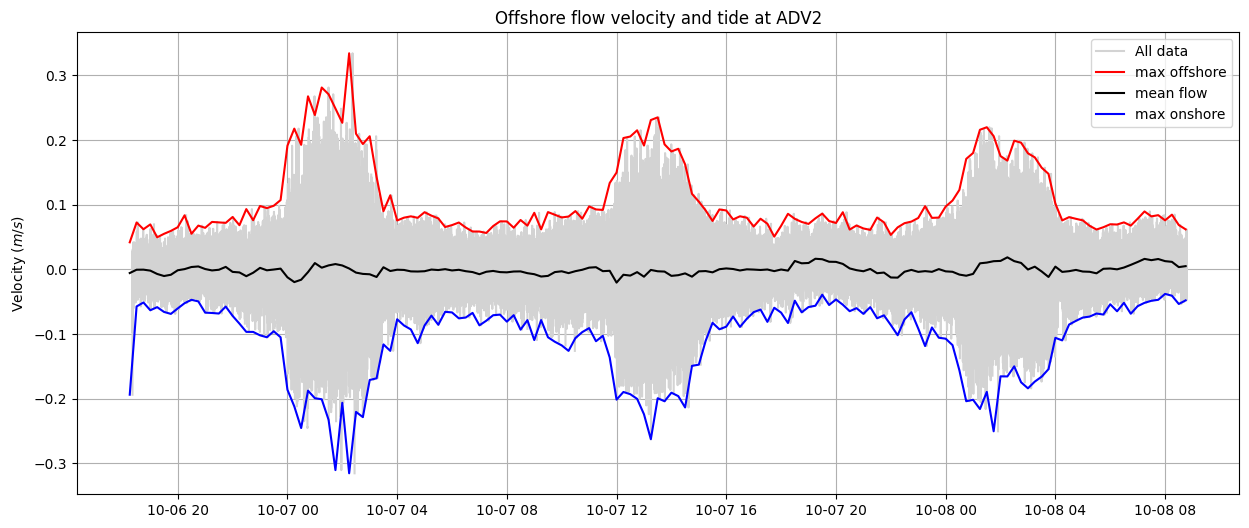

In [32]:
direction = 1
cflow, direc = get_direction(direction)
fig, ax = plt.subplots(figsize = (15,6))
ax.plot(ds.variables['time'],ds.variables['vel'][direction], label = 'All data', color = 'lightgrey')
ax.plot(ds_rsp_max.time, ds_rsp_max.vel[:,direction], c ='r', label = 'max offshore')
ax.plot(ds_rsp_max.time, ds_rsp_mean.vel[:,direction], color='k', label = 'mean flow')
ax.plot(ds_rsp_max.time, ds_rsp_min.vel[:,direction], color='b', label = 'max onshore')
plt.legend()
ax.set_title('%s flow velocity and tide at ADV2' %(direc))
ax.set_ylabel('Velocity $(m/s)$')
plt.grid()
plt.savefig('max_min_%s_%s.png'%(direc, ds.deployment_name))

plt.show()


In [36]:
###### Add 'hours' for time since start for plotting:
time_data = ds['time'].values
time_difference = ((time_data - time_data[0]) / np.timedelta64(1, 'h'))
ds.coords['hours'] = xr.DataArray(time_difference, dims=['time'])


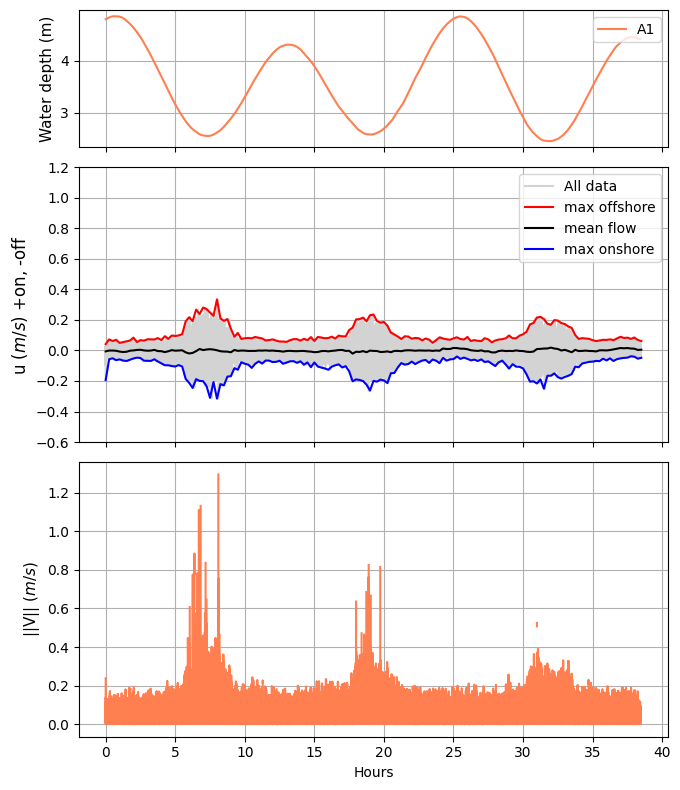

In [37]:
fig, (ax, ax1, ax3) = plt.subplots(3, 1, figsize=(7, 8), sharex=True,  gridspec_kw={'height_ratios': [1,2,2]})
fontsizes = 11
# Plot 1
ax.plot(ds.variables['hours'], smooth_line(ds.variables['depth'][:]), c='coral', label='A1')
# ax.plot(ds2.variables['hours'], smooth_line(ds2.variables['depth'][:]), c='teal', label='A2')
ax.grid()
ax.set_ylabel('Water depth (m)', fontsize=fontsizes)  # Increase font size of y-axis label
#ax.get_xaxis().set_visible(False)  # Remove x-axis labels and ticks
ax.legend(loc = 'upper right')
ax.set_title('')  # Remove the title

# Plot 1
direction = 1
ax1.plot(ds.variables['hours'], ds.variables['vel'][direction], label='All data', color='lightgrey')
ax1.plot(ds_rsp_max.variables['hours'], ds_rsp_max.variables['vel'][:, direction], c='r', label='max offshore')
ax1.plot(ds_rsp_mean.variables['hours'], ds_rsp_mean.variables['vel'][:, direction], color='k', label='mean flow')
ax1.plot(ds_rsp_min.variables['hours'], ds_rsp_min.variables['vel'][:, direction], color='b', label='max onshore')
ax1.set_ylabel('u $(m/s)$ +on, -off', fontsize=12)  # Increase font size of y-axis label
ax1.set_ylim(-0.6, 1.2)
ax1.grid()
#ax1.get_xaxis().set_visible(False)  # Remove x-axis labels and ticks
ax1.legend().set_visible(False)  # Remove legend
ax1.set_title('')  # Remove the title

# Plot 2
# ax2.plot(ds2.variables['hours'], ds2.variables['vel'][direction], label='All data', color='lightgrey')
# ax2.plot(ds2_rsp_max.variables['hours'], ds2_rsp_max.variables['vel'][:,direction], c='r', label='max offshore')
# ax2.plot(ds2_rsp_mean.variables['hours'], ds2_rsp_mean.variables['vel'][:,direction], color='k', label='mean flow')
# ax2.plot(ds2_rsp_min.variables['hours'], ds2_rsp_min.variables['vel'][:,direction], color='b', label='max onshore')
# ax2.set_ylabel('u $(m/s)$ +on, -off', fontsize=fontsizes)  # Increase font size of y-axis label
# ax2.set_ylim(-0.6, 1.2)
# ax2.grid()
# #ax2.get_xaxis().set_visible(False)  # Remove x-axis labels and ticks
# ax2.legend().set_visible(False)  # Remove legend
# ax2.set_title('')  # Remove the title

# Plot 3
# ax3.plot(ds2.variables['hours'], ds2['vel_mag2D'], label='A2', c = 'teal')
ax3.plot(ds.variables['hours'], ds['vel_mag2D'], label='A1', c = 'coral')
ax3.grid()
ax3.set_ylabel('||V|| $(m/s)$', fontsize=fontsizes)  # Increase font size of y-axis label
ax3.set_xlabel('Hours')
ax3.set_title('')  # Remove the title
#ax3.legend()

# Set a common legend for both subplots
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels)

# Define a function to format the date and time
#date_format = mdates.DateFormatter("%d %H:%M")

# Format the X-axis with the specified date format
#ax3.xaxis.set_major_formatter(date_format)

# Remove the space between subplots
plt.subplots_adjust(hspace=0)

# Save and display the combined figure
plt.tight_layout()
plt.savefig('202310_combined_plots.png', transparent = True)
plt.show()

And then lets explore the data a little more:

### Look at times of low tides. 
To find low tide times just by slicing the times:


In [20]:
ds_binned


<xarray.Dataset>
Dimensions:               (time: 230, dir: 3, beam: 3, earth: 3, inst: 3,
                           tke: 3, tau: 3, S: 3, freq: 600, C: 3, coh_freq: 600)
Coordinates:
  * time                  (time) datetime64[ns] 2022-10-06T18:26:00.062023162...
  * dir                   (dir) <U1 'E' 'N' 'U'
  * beam                  (beam) int64 1 2 3
  * earth                 (earth) <U1 'E' 'N' 'U'
  * inst                  (inst) <U1 'X' 'Y' 'Z'
  * tke                   (tke) <U5 'upup_' 'vpvp_' 'wpwp_'
  * tau                   (tau) <U5 'upvp_' 'upwp_' 'vpwp_'
  * S                     (S) <U3 'Sxx' 'Syy' 'Szz'
  * freq                  (freq) float32 0.006667 0.01333 0.02 ... 3.993 4.0
  * C                     (C) <U3 'Cxy' 'Cxz' 'Cyz'
  * coh_freq              (coh_freq) float32 0.006667 0.01333 0.02 ... 3.993 4.0
Data variables: (12/38)
    U_std                 (time) float32 0.02751 0.02705 ... 0.02614 0.02606
    batt                  (time) float32 13.12 13.1 13.1 ... 11.6 11.6 11.6
    c_sound               (time) float32 1.53e+03 1.53e+03 ... 1.528e+03
    heading               (time) float32 207.8 208.6 208.8 ... 209.9 209.9 209.9
    pitch                 (time) float32 22.74 21.92 21.68 ... 21.14 21.15 21.13
    roll                  (time) float32 -20.47 -20.06 -19.98 ... -19.76 -19.76
    ...                    ...
    pressure_var          (time) float32 0.004051 0.004522 ... 0.0033 0.003543
    orientmat_var         (earth, inst, time) float32 0.0002393 ... 1.542e-07
    water_density_var     (time) float32 4.748e-06 1.598e-06 ... 7.335e-07
    depth_var             (time) float32 0.004006 0.004472 ... 0.003263 0.003504
    csd                   (C, time, coh_freq) complex64 (nan+nanj) ... (1.225...
    TI                    (time) float32 3.606 7.991 7.943 ... 1.162 1.547 3.531
Attributes: (12/46)
    inst_make:                   Nortek
    inst_model:                  Vector
    inst_type:                   ADV
    rotate_vars:                 ['vel']
    n_beams:                     3
    profile_mode:                continuous
    ...                          ...
    declination_in_orientmat:    1
    principal_heading:           74.0234
    n_bin:                       4800.0
    n_fft:                       1200.0
    n_fft_coh:                   1200
    description:                 Binned averages calculated from ensembles of...

In [12]:
#Set start and end times:


start = '2022-10-06 23:00:00'
end  = '2022-10-07 04:00:00'

def sliced_plot(data,start,end):
    ds_slice = data.sel(time=slice(start,end))
    quickplot(ds_slice,'pressure', direction = 1, smooth_tide=False)
    
    
    print('Data from period %s to %s'%(start,end))
    if (ds_slice.vel[1].mean(skipna=True).values) > 0:
        print('Mean flow is offshore at  %s m/s'%(np.absolute(ds_slice.vel[1].mean(skipna=True).values)))
    else:
        print('Mean flow is onshore at %s m/s'%(np.absolute(ds_slice.vel[1].mean(skipna=True).values)))  
    print('Max offshore velocity: %s m/s' %(np.absolute(ds_slice.vel[1].max(skipna=True).values)))
    print('Max onshore velocity: %s m/s' %(np.absolute(ds_slice.vel[1].min(skipna=True).values)))
    
    
    
   

Veloicty in groove direction, + is offshore, - is onshore


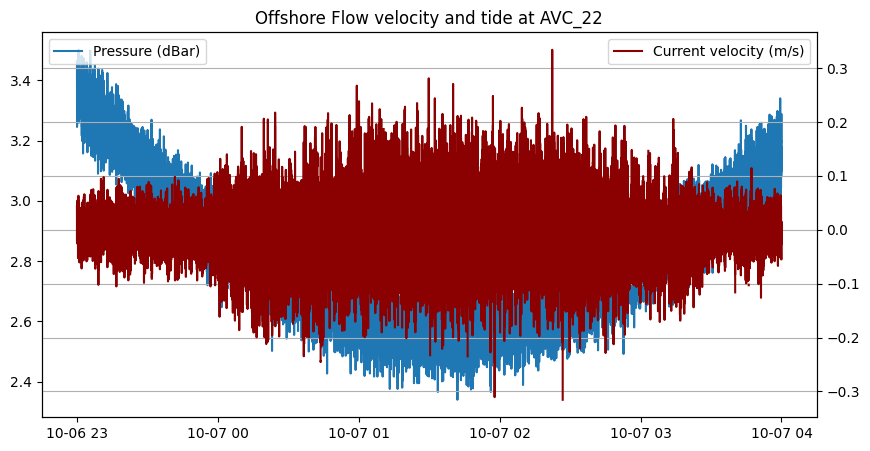

Data from period 2022-10-06 23:00:00 to 2022-10-07 04:00:00
Mean flow is onshore at 0.002429609585465079 m/s
Max offshore velocity: 0.3341882843263506 m/s
Max onshore velocity: 0.3155123501220347 m/s


In [13]:
sliced_plot(ds,start,end)
#sliced_plot(ds2,start,end)

Veloicty in groove direction, + is offshore, - is onshore


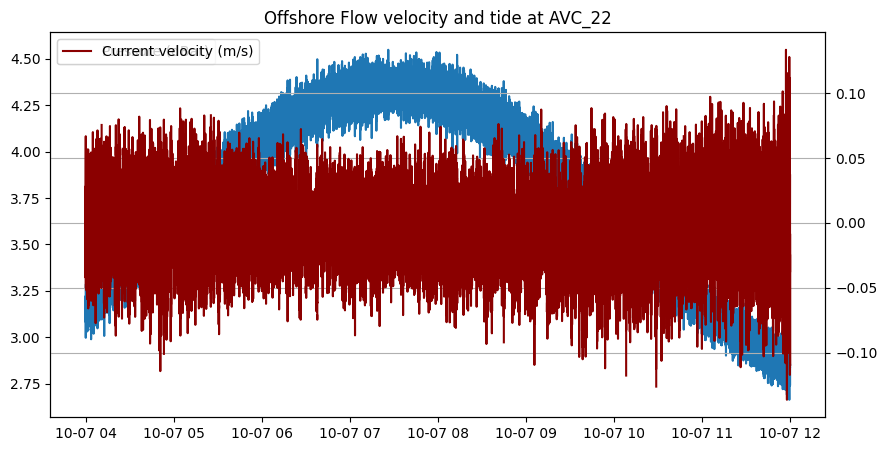

Data from period 2022-10-07 04:00:00 to 2022-10-07 12:00:00
Mean flow is onshore at 0.003206695399595626 m/s
Max offshore velocity: 0.13350951292333288 m/s
Max onshore velocity: 0.1363403834768894 m/s


In [14]:
start = '2022-10-07 04:00:00'
end  = '2022-10-07 12:00:00'

sliced_plot(ds,start,end)
#sliced_plot(ds2,start,end)

Veloicty in groove direction, + is offshore, - is onshore


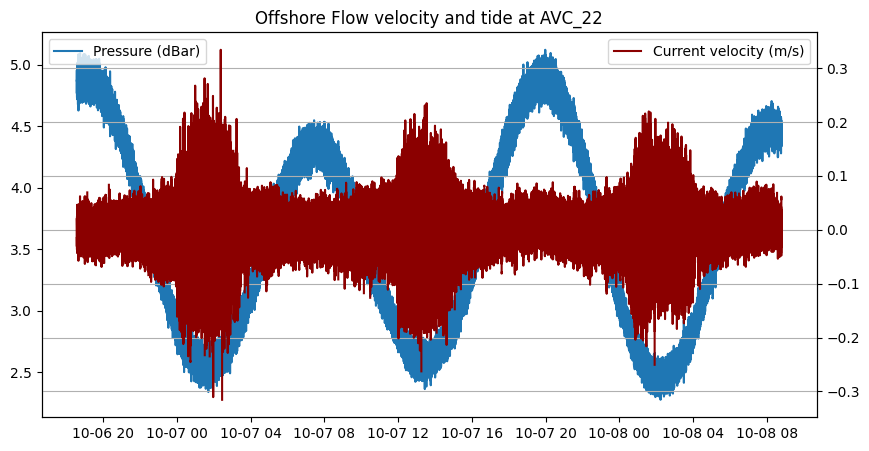

Data from period 2022-10-06 18:34:00 to 2022-10-08 08:47:00
Mean flow is onshore at 0.0009585917332193061 m/s
Max offshore velocity: 0.3341882843263506 m/s
Max onshore velocity: 0.3155123501220347 m/s


In [15]:
start = '2022-10-06 18:34:00'
end  = '2022-10-08 08:47:00'
sliced_plot(ds,start,end)
#sliced_plot(ds2,start,end)

Veloicty in groove direction, + is offshore, - is onshore


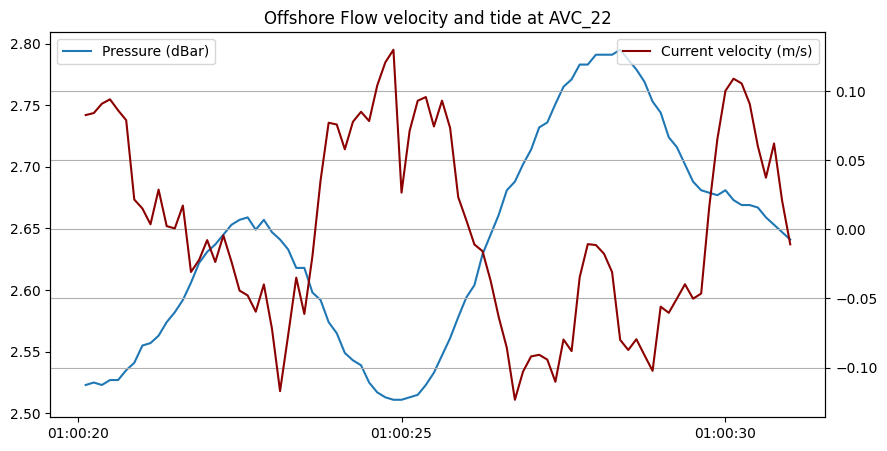

Data from period 2022-10-07 01:00:20 to 2022-10-07 01:00:30
Mean flow is offshore at  0.0014739915972998689 m/s
Max offshore velocity: 0.1298095193737226 m/s
Max onshore velocity: 0.12332063018586702 m/s


In [16]:
start = '2022-10-07 01:00:20'
end  = '2022-10-07 01:00:30'
sliced_plot(ds,start,end)
#sliced_plot(ds2,start,end)

## Radial plots of vector data 

In [38]:
u = ds.variables["vel"][0]
v = ds.variables["vel"][1]

resultant_vector = np.sqrt(u**2 + v**2)
#direction = np.degrees(np.arctan2(v, u))
def get_polar_angle(ds):
# Calculate the polar angle (angle in the xy plane)
    ds['polar_angle'] = np.degrees(np.arctan2(ds['vel'][1], ds['vel'][0]))
get_polar_angle(ds)

In [39]:
print(resultant_vector.max().values,
    resultant_vector.mean().values,
    resultant_vector.min().values)

1.2943259678038619 0.05877343408312331 2.84157446094809e-10


In [45]:
# Convert direction to radians
def radial_plot(ds, instr):
    u = ds.variables["vel"][0]
    v = ds.variables["vel"][1]
    resultant_vector = np.sqrt(u**2 + v**2)
    direction = np.degrees(np.arctan2(v, u))

    direction_rad = np.deg2rad(direction)
    
    
    # Calculate the circular mean
    circular_mean = np.arctan2(np.mean(np.sin(direction_rad)), np.mean(np.cos(direction_rad)))

    # Convert the circular mean back to degrees
    circular_mean_deg = np.rad2deg(circular_mean)
    

    # Create a polar scatter plot
    fig, ax = plt.subplots(figsize = (10,10), subplot_kw={'projection': 'polar'})
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_title(f"Flow velocity {instr}", pad=20)
    size =  (2*resultant_vector**2)
    sc = ax.scatter(direction_rad, resultant_vector, c=resultant_vector, s=size, cmap='viridis', vmin=0, vmax=2)

    
    #Convert from -180 to 180 to 0 to 360
    if circular_mean_deg < 0:
        mean_dir_print = circular_mean_deg + 360
    else:
        mean_dir_print = circular_mean_deg
    
    ax.plot([circular_mean, circular_mean], [0, resultant_vector.max()], color='red', linestyle='--', label=f"Mean direction = {(mean_dir_print):.1f} deg")
    ax.legend()

    ax.set_rmax(1.6)
    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax, label="Flow velocity (m/s)", extend='both', pad=0.1)
    #plt.savefig(f"202310_new_radial_plot_{instr}.png")
    #plt.show()

#radial_plot(ds)    
#radial_plot(ds2)

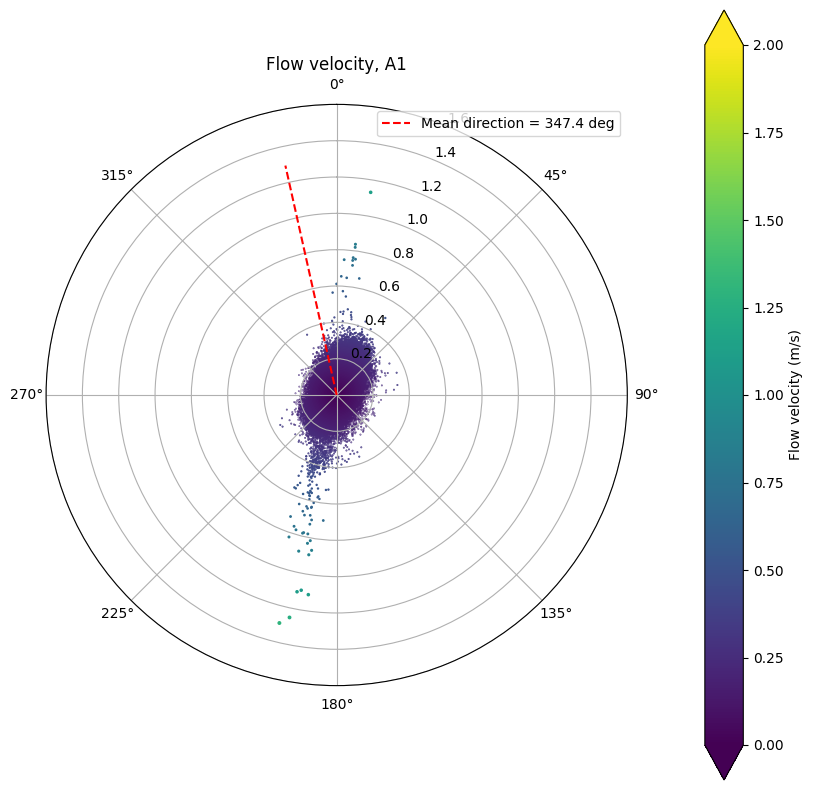

In [46]:
radial_plot(ds, 'A1')
plt.title('Flow velocity, A1')
plt.show()


## Consider tidal phase:

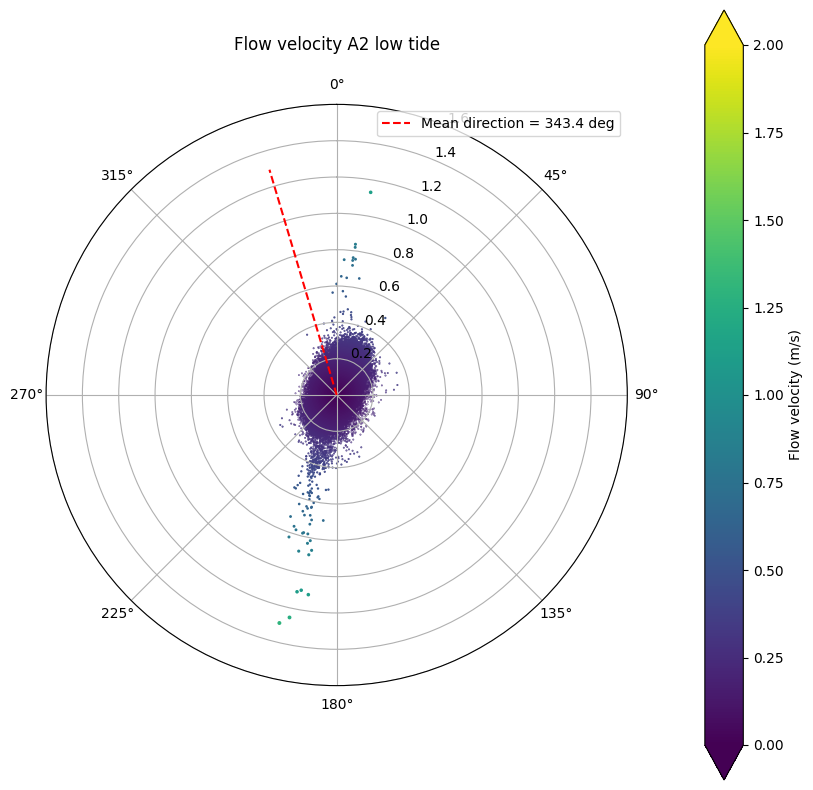

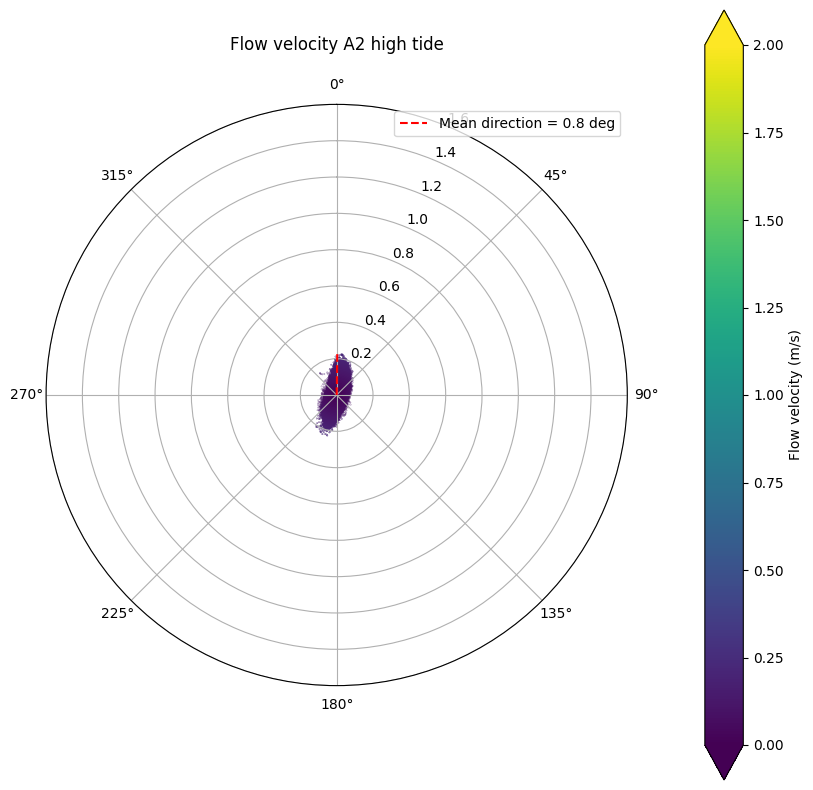

In [47]:
radial_plot(ds_low_tide, 'A2 low tide')
radial_plot(ds_high_tide, 'A2 high tide')

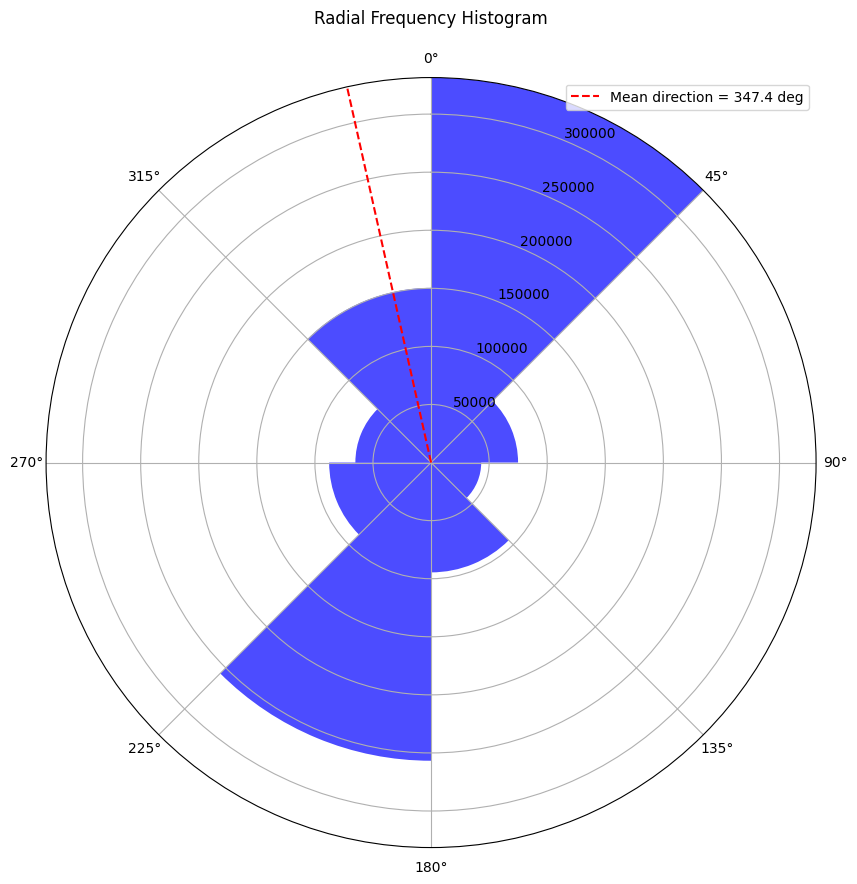

In [19]:

def radial_histogram_plot(ds):
    u = ds.variables["vel"][0]
    v = ds.variables["vel"][1]
    resultant_vector = np.sqrt(u**2 + v**2)
    direction = np.degrees(np.arctan2(v, u))

    direction_rad = np.deg2rad(direction)
    
     # Calculate the circular mean
    circular_mean = np.arctan2(np.mean(np.sin(direction_rad)), np.mean(np.cos(direction_rad)))

    # Convert the circular mean back to degrees
    circular_mean_deg = np.rad2deg(circular_mean)

    # Create a polar histogram plot with 8 bins
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_title("Radial Frequency Histogram", pad=20)

    # Calculate histogram in seconds
    sample_rate = 8  # Hz
    time_per_sample = 1 / sample_rate  # seconds per sample
    hist, bin_edges = np.histogram(direction_rad, bins=8)
    hist_seconds = hist / (sample_rate / 8)  # Convert from samples to seconds

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Plot the histogram bars
    ax.bar(bin_centers, hist_seconds, width=(2 * np.pi / 8), align='center', alpha=0.7, color='blue')


    if circular_mean_deg < 0:
        mean_dir_print = circular_mean_deg + 360
    else:
        mean_dir_print = circular_mean_deg
    
    ax.plot([circular_mean, circular_mean],  [0, np.max(hist_seconds)], color='red', linestyle='--', label=f"Mean direction = {(mean_dir_print):.1f} deg")
    ax.legend()
    
    ax.legend()

    # Set the radius limit
    ax.set_rmax(np.max(hist_seconds) + 2)  # Adding a buffer to the limit

    plt.show()

 
ds_cleaned = ds.dropna(dim='time')
# Call the function with your dataset (ds)
radial_histogram_plot(ds_cleaned)